In [1]:
import projectpath

import cobra
import json
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time

from mosmo.model import Molecule, Reaction, ReactionNetwork
from mosmo.calc import fba_gd

jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))

def labels(entries):
    return [entry.label for entry in entries]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Test network: e_coli_core from cobra

In [2]:
cobra_model = cobra.io.load_model("e_coli_core")
cobra_solution = cobra_model.optimize()

# Convert all bigg molecule dicts to Molecule objects
mols = {
    cobra_mol.id: Molecule(
        id=cobra_mol.id,
        name=cobra_mol.name,
        formula=cobra_mol.formula,
        charge=cobra_mol.charge,
    )
    for cobra_mol in cobra_model.metabolites
}

# Sort bigg reactions into "real" reactions, boundaries, and biomass components
reactions = {}
boundaries = {}
biomass_components = {}
flux_targets = {}
for cobra_reaction in cobra_model.reactions:
    if len(cobra_reaction.metabolites) == 1:
        # Exchange => boundary molecule, with targets (lb, ub)
        mol = mols[next(iter(cobra_reaction.metabolites)).id]
        lb, ub = cobra_reaction.bounds
        if lb == -1000:
            lb = None
        if ub == 1000:
            ub = None
        boundaries[mol] = (lb, ub)

    elif cobra_reaction.id== "BIOMASS_Ecoli_core_w_GAM":
        # Biomass components, with targets
        for component, amount in cobra_reaction.metabolites.items():
            biomass_components[mols[component.id]] = -amount

    else:
        rxn = Reaction(
            id=cobra_reaction.id,
            name=cobra_reaction.name,
            stoichiometry={mols[mol.id]: count for mol, count in cobra_reaction.metabolites.items()},
            reversible=cobra_reaction.reversibility,
        )
        reactions[rxn.id] = rxn

        # Capture any non-trivial reaction flux targets (i.e. for ATPM)
        lb, ub = cobra_reaction.bounds
        if lb > 0:
            flux_targets[rxn] = (lb, ub if ub != 1000 else None)
        if ub < 0:
            flux_targets[rxn] = (lb if lb != -1000 else None, ub)

network = ReactionNetwork(reactions.values())
intermediates = set(network.reactants) - boundaries.keys() - biomass_components.keys()
print(f"{len(reactions)} reactions on {len(mols)} molecules")
print(f"{len(intermediates)} intermediates; {len(boundaries)} boundaries; {len(biomass_components)} biomass components")
print(f"{len(flux_targets)} flux targets")

74 reactions on 72 molecules
29 intermediates; 20 boundaries; 23 biomass components
1 flux targets


In [3]:
biomass_components

{[3pg_c] 3-Phospho-D-glycerate: 1.496,
 [accoa_c] Acetyl-CoA: 3.7478,
 [atp_c] ATP C10H12N5O13P3: 59.81,
 [e4p_c] D-Erythrose 4-phosphate: 0.361,
 [f6p_c] D-Fructose 6-phosphate: 0.0709,
 [g3p_c] Glyceraldehyde 3-phosphate: 0.129,
 [g6p_c] D-Glucose 6-phosphate: 0.205,
 [gln__L_c] L-Glutamine: 0.2557,
 [glu__L_c] L-Glutamate: 4.9414,
 [h2o_c] H2O H2O: 59.81,
 [nad_c] Nicotinamide adenine dinucleotide: 3.547,
 [nadph_c] Nicotinamide adenine dinucleotide phosphate - reduced: 13.0279,
 [oaa_c] Oxaloacetate: 1.7867,
 [pep_c] Phosphoenolpyruvate: 0.5191,
 [pyr_c] Pyruvate: 2.8328,
 [r5p_c] Alpha-D-Ribose 5-phosphate: 0.8977,
 [adp_c] ADP C10H12N5O10P2: -59.81,
 [akg_c] 2-Oxoglutarate: -4.1182,
 [coa_c] Coenzyme A: -3.7478,
 [h_c] H+: -59.81,
 [nadh_c] Nicotinamide adenine dinucleotide - reduced: -3.547,
 [nadp_c] Nicotinamide adenine dinucleotide phosphate: -13.0279,
 [pi_c] Phosphate: -59.81}

### Basic constraints
- SteadyStateObjective for internal (non-boundary, _non-biomass_) reactants
- IrreversibilityObjective for irreversibility
- ProductionObjective for boundaries/exchanges
- VelocityObjective for flux targets
- BiomassObjective (new) for biomass (requires growth rate as param)

In [3]:
class BiomassObjective(fba_gd.Objective):
    def __init__(self, network, biomass_components, growth_rate, weight=1.0):
        super().__init__(weight)
        self.network = network
        self.indices = np.array([network.reactants.index_of(component) for component in biomass_components.keys()], dtype=np.int32)
        self.fractions = network.reactants.pack(biomass_components)[self.indices]
        self.growth_rate = growth_rate
    
    def params(self):
        return self.growth_rate
    
    def update_params(self, growth_rate):
        self.growth_rate = growth_rate

    def residual(self, velocities, dmdt, growth_rate):
        expected = growth_rate * self.fractions
        actual = dmdt[self.indices]
        return actual - expected

ss_objective = fba_gd.SteadyStateObjective(network, intermediates)
irrev_objective = fba_gd.IrreversibilityObjective(network)
bounds_objective = fba_gd.ProductionObjective(network, {target: (lb, ub) for target, (lb, ub) in boundaries.items() if lb is not None or ub is not None})
flux_objective = fba_gd.VelocityObjective(network, flux_targets)
biomass_objective = BiomassObjective(network, biomass_components, cobra_solution.objective_value)

print(f"{len(ss_objective.indices)} steady-state targets")
print(f"{len(irrev_objective.indices)} irreversibility targets")
print(f"{len(bounds_objective.indices)} boundary targets")
print(f"{len(flux_objective.indices)} flux targets")
print(f"{len(biomass_objective.indices)} biomass targets")

29 steady-state targets
35 irreversibility targets
14 boundary targets
1 flux targets
23 biomass targets


## Maximize growth as an objective, via constrained optimization

### Translate basic objectives into LinearConstraint or Bounds objects
- flux_objective, irrev_objective => Bounds (i.e. constrain flux variables directly)
- ss_objective, bounds_objective => LinearConstraint (i.e. constrain $S \cdot v$)
- treat biomass as traditional FBA does: augment the S matrix, then treat the biomass components as intermediates, with a LinearConstraint on augmented $S \cdot v$

In [22]:
def augmented_s(network, biomass_components):
    biomass = network.reactants.pack(biomass_components)
    return np.hstack([biomass[:, np.newaxis], network.s_matrix])

def sv_constraint(s_matrix, indices, bounds):
    return s_matrix[indices], bounds[0], bounds[1]

def flux_bounds(network, *bounds_list):
    lb = np.full(network.shape[1], -np.inf)
    ub = np.full(network.shape[1], np.inf)
    for bounds in bounds_list:
        for reaction, (_lb, _ub) in bounds.items():
            i = network.reactions.index_of(reaction)
            if _lb is not None and lb[i] < _lb:
                lb[i] = _lb
            if _ub is not None and ub[i] > _ub:
                ub[i] = _ub
    return lb, ub
    

In [27]:
scipy.optimize.Bounds(*flux_bounds(
    network, 
    flux_targets,
    {reaction: (0, None) for reaction in network.reactions if not reaction.reversible},
)).__dict__

{'lb': array([0.  , 0.  , -inf, -inf, 0.  , -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, 0.  , -inf, -inf, 8.39, 0.  , -inf, 0.  , -inf, 0.  , -inf,
        -inf, 0.  , -inf, -inf, -inf, 0.  , -inf, 0.  , 0.  , -inf, -inf,
        0.  , -inf, 0.  , -inf, -inf, 0.  , -inf, -inf, -inf, -inf, 0.  ,
        0.  , 0.  , 0.  , 0.  , -inf, 0.  , -inf, -inf, 0.  , 0.  , 0.  ,
        -inf, 0.  , 0.  , -inf, 0.  , -inf, -inf, 0.  , -inf, 0.  , 0.  ,
        -inf, 0.  , 0.  , 0.  , 0.  , -inf, -inf, 0.  ]),
 'ub': array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf]),
 'keep_feasible': array([False, False, False, False, False, False,

In [26]:
scipy.optimize.LinearConstraint(*sv_constraint(augmented_s(network, biomass_components), ss_objective.indices, [0, 0])).__dict__

{'A': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 'lb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'ub': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'keep_feasible': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False])}

In [14]:
class MultiObjective:
    def __init__(self, objectives):
        self.objectives = {name: objective for name, objective in objectives.items()}
    
    def residuals(self, velocities, dmdt, params=None):
        params = params or {}
        result = {}
        for name, objective in self.objectives.items():
            param = params.get(name)
            if param is None:
                param = objective.params()
            result[name] = objective.residual(velocities, dmdt, param)
        return result

objectives = MultiObjective({
    "steady-state": ss_objective,
    "irrev": irrev_objective,
    "bounds": bounds_objective,
    "fluxes": flux_objective,
    "growth": biomass_objective
})

def residuals(x):
    growth_rate = x[0].astype(float)
    velocities = x[1:]
    dmdt = network.s_matrix @ velocities
    return jnp.concatenate(list(objectives.residuals(velocities, dmdt, {"growth": growth_rate}).values()))

constr_jit = jax.jit(residuals)
constr_jac = jax.jit(jax.jacfwd(residuals))
constr_hess = jax.jit(jax.jacfwd(constr_jac))

### Before invoking minimize(), confirm expected behavior compared to cobra

In [15]:
res = objectives.residuals(fluxv_cobra, dmdtv_cobra)
for name, residual in res.items():
    print(name, residual)
print()

x = jnp.insert(fluxv_cobra, 0, cobra_solution.objective_value)
res_full = jnp.concatenate(list(res.values()))
# print(jnp.all(constr_jit(x) == res_full))
print(jnp.sum(jnp.square((constr_jit(x) - res_full))))

steady-state [ 0.00000000e+00  0.00000000e+00  7.10542736e-15  0.00000000e+00
  0.00000000e+00 -2.22044605e-16 -7.49400542e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22044605e-16
  0.00000000e+00  0.00000000e+00 -8.88178420e-16  2.88516672e-15
  0.00000000e+00  1.97974444e-14  8.88178420e-16  0.00000000e+00
  8.88178420e-16  8.88178420e-16 -3.55271368e-15  0.00000000e+00
  6.31088724e-30  0.00000000e+00 -7.10542736e-15  0.00000000e+00
 -3.55271368e-15]
irrev [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
bounds [-3.19221472e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.77635684e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
fluxes [0.]
growth [ 1.99840144e-15  0.00000000e+00  5.32907052e-13

### Same as above, monitor behavior over range of growth rates

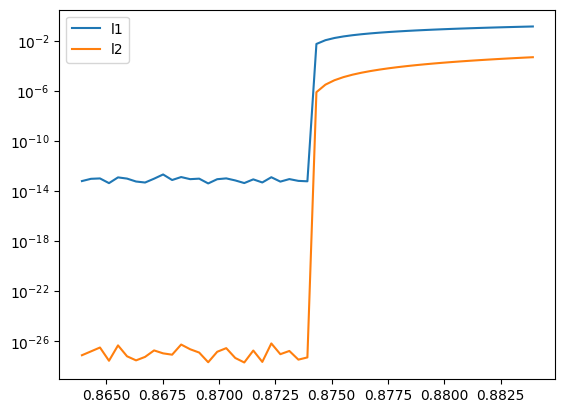

In [16]:
def assess(growth_rate, fba_result):
    x = jnp.insert(fba_result.velocities, 0, growth_rate)
    res_full = constr_jit(x)
    return {
        "growth": growth_rate,
        "l1": jnp.sum(jnp.abs(res_full)),
        "l2": jnp.sum(jnp.square(res_full))
    }
assess_df = pd.DataFrame(assess(*result) for result in results)
plt.plot(assess_df["growth"], assess_df["l1"], label="l1")
plt.plot(assess_df["growth"], assess_df["l2"], label="l2")
plt.yscale("log")
plt.legend()
plt.show()

## Finally, try minimize()
- x[0] is growth rate, x[1:] is v
- Constraints go in an instance of scipy.optimize.NonLinearContraint
- The "function" to minimize returns -x[0] -- jacobian (grad) and hessian are trivial

In [17]:
xlen = 1 + network.shape[1]
x0=jax.random.uniform(prng, shape=(xlen,))
jac_const = -jnp.eye(xlen)[0]
hess_const = jnp.zeros(xlen)
lb = np.array([0] + [-np.inf] * network.shape[1])
ub = np.full(xlen, np.inf)

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=lambda x: -x[0].astype(float),
    jac=lambda x: jac_const,
    hess=lambda x: hess_const,
    x0=x0,
    bounds=scipy.optimize.Bounds(lb=lb, ub=ub, keep_feasible=True),
    constraints=scipy.optimize.NonlinearConstraint(
        fun=constr_jit,
        jac=constr_jac,
        # hess=constr_hess,  TODO: figure out this Hessian stuff
        lb=0,
        ub=0,
    ),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = network.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(residuals(soln.x)))}")
print()
objectives.residuals(velocities, dmdt, {"growth": growth_rate})


/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Growth rate = 1.6279957442260724e-12
Loss = 373.1662516120457



{'steady-state': array([-0.76195728, -1.38949156,  0.62096889,  0.50944013,  0.79029891,
        -0.24182227,  1.40638802, -0.50394773, -0.86460596,  0.20252751,
         0.35572046, -0.93157745,  2.09940171,  1.65569346,  0.49190064,
         0.08913025,  0.10718661,  0.42850431,  0.72280312, -0.86665374,
        -0.22747629,  0.64552509, -0.34967261, -0.17918986,  0.51423291,
        -0.24564402, -0.62096889,  0.20446538,  0.91703895]),
 'irrev': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=float64),
 'bounds': Array([-0.63163823, -0.76608999, -0.85178324,  0.        , -0.93064771,
        -0.65957034, -0.65718449, -0.06460374,  0.        , -0.06378649,
        -0.86809164,  0.        ,  0.        , -0.69183396, -0.14310074,
         0.        ,  0.        ,  0.        , -0.88070131, -0.29883542],      dtype=float64),
 'fluxes': Array([-7.59595056], dtype=float

### Focus on a much smaller problem to debug this

In [18]:
list(enumerate(network.reactions))

[(0, [ACALD] acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c),
 (1, [ACALDt] acald_e <=> acald_c),
 (2, [ACKr] ac_c + atp_c <=> actp_c + adp_c),
 (3, [ACONTa] cit_c <=> acon_C_c + h2o_c),
 (4, [ACONTb] acon_C_c + h2o_c <=> icit_c),
 (5, [ACt2r] ac_e + h_e <=> ac_c + h_c),
 (6, [ADK1] amp_c + atp_c <=> 2.0 adp_c),
 (7, [AKGDH] akg_c + coa_c + nad_c => co2_c + nadh_c + succoa_c),
 (8, [AKGt2r] akg_e + h_e <=> akg_c + h_c),
 (9, [ALCD2x] etoh_c + nad_c <=> acald_c + h_c + nadh_c),
 (10, [ATPM] atp_c + h2o_c => adp_c + h_c + pi_c),
 (11, [ATPS4r] adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c),
 (12, [CO2t] co2_e <=> co2_c),
 (13, [CS] accoa_c + h2o_c + oaa_c => cit_c + coa_c + h_c),
 (14, [CYTBD] 2.0 h_c + 0.5 o2_c + q8h2_c => h2o_c + 2.0 h_e + q8_c),
 (15, [D_LACt2] h_e + lac__D_e <=> h_c + lac__D_c),
 (16, [ENO] 2pg_c <=> h2o_c + pep_c),
 (17, [ETOHt2r] etoh_e + h_e <=> etoh_c + h_c),
 (18, [FBA] fdp_c <=> dhap_c + g3p_c),
 (19, [FBP] fdp_c + h2o_c => f6p_c + pi_c),
 (20, [FORt2]

In [19]:
baby = ReactionNetwork([network.reactions[52], network.reactions[50], network.reactions[18], network.reactions[73]])
pd.DataFrame(baby.s_matrix, index=labels(baby.reactants), columns=labels(baby.reactions))

,PGI,PFK,FBA,TPI
g6p_c,-1.0,0.0,0.0,0.0
f6p_c,1.0,-1.0,0.0,0.0
atp_c,0.0,-1.0,0.0,0.0
adp_c,0.0,1.0,0.0,0.0
fdp_c,0.0,1.0,-1.0,0.0
h_c,0.0,1.0,0.0,0.0
dhap_c,0.0,0.0,1.0,-1.0
g3p_c,0.0,0.0,1.0,1.0


In [20]:
b_objectives = MultiObjective({
    "steady-state": fba_gd.SteadyStateObjective(baby, [baby.reactants[1], baby.reactants[4]], weight=1e4),
    "irrev": fba_gd.IrreversibilityObjective(baby, weight=1e4),
    "bounds": fba_gd.ProductionObjective(baby, {baby.reactants[0]: (-10., 0), baby.reactants[6]: (0, None)}, weight=1e2),
    "growth": BiomassObjective(baby, {baby.reactants[7]: 1.}, 1.)
})

def b_residuals(x):
    growth_rate = x[0].astype(float)
    velocities = x[1:]
    dmdt = baby.s_matrix @ velocities
    return jnp.concatenate(list(b_objectives.residuals(velocities, dmdt, {"growth": growth_rate}).values()))

In [21]:
bx2 = jnp.array([2., 1., 1., 1., 1])
b_residuals(bx2)

Array([0., 0., 0., 0., 0., 0.], dtype=float64)

In [22]:
v = np.array([1, 1, 1, .5])
print(baby.reactions.unpack(v))
print(baby.reactants.unpack(baby.s_matrix @ v))

{[PGI] g6p_c <=> f6p_c: 1.0, [PFK] atp_c + f6p_c => adp_c + fdp_c + h_c: 1.0, [FBA] fdp_c <=> dhap_c + g3p_c: 1.0, [TPI] dhap_c <=> g3p_c: 0.5}
{[g6p_c] D-Glucose 6-phosphate: -1.0, [f6p_c] D-Fructose 6-phosphate: 0.0, [atp_c] ATP: -1.0, [adp_c] ADP: 1.0, [fdp_c] D-Fructose 1,6-bisphosphate: 0.0, [h_c] H+: 1.0, [dhap_c] Dihydroxyacetone phosphate: 0.5, [g3p_c] Glyceraldehyde 3-phosphate: 1.5}


In [23]:
bxlen = 1 + baby.shape[1]
bx0=jax.random.uniform(prng, shape=(bxlen,))
bjac_const = -jnp.eye(bxlen)[0]
blb = np.array([0] + [-np.inf] * baby.shape[1])
bub = np.full(bxlen, np.inf)

def bfun(x):
    return -x[0].astype(float)

bconstr_jit = jax.jit(b_residuals)
bconstr_jac = jax.jit(jax.jacfwd(b_residuals))

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=jax.jit(bfun),
    jac=jax.jit(jax.jacfwd(bfun)),
    x0=bx0,
    bounds=scipy.optimize.Bounds(lb=blb, ub=bub, keep_feasible=True),
    constraints=scipy.optimize.NonlinearConstraint(
        fun=bconstr_jit,
        jac=bconstr_jac,
        lb=0,
        ub=0,
    ),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = baby.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(b_residuals(soln.x)))}")
print()
b_objectives.residuals(velocities, dmdt, {"growth": growth_rate})


Growth rate = 0.8691411774261413
Loss = 0.0



/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


{'steady-state': array([0., 0.]),
 'irrev': Array([0.], dtype=float64),
 'bounds': Array([0., 0.], dtype=float64),
 'growth': array([0.])}

In [24]:
baby.reactions.unpack(soln.x[1:])

{[PGI] g6p_c <=> f6p_c: 0.43457058871307064,
 [PFK] atp_c + f6p_c => adp_c + fdp_c + h_c: 0.43457058871307064,
 [FBA] fdp_c <=> dhap_c + g3p_c: 0.43457058871307064,
 [TPI] dhap_c <=> g3p_c: 0.43457058871307064}

In [25]:
baby.reactants.unpack(baby.s_matrix @ soln.x[1:])

{[g6p_c] D-Glucose 6-phosphate: -0.43457058871307064,
 [f6p_c] D-Fructose 6-phosphate: 0.0,
 [atp_c] ATP: -0.43457058871307064,
 [adp_c] ADP: 0.43457058871307064,
 [fdp_c] D-Fructose 1,6-bisphosphate: 0.0,
 [h_c] H+: 0.43457058871307064,
 [dhap_c] Dihydroxyacetone phosphate: 0.0,
 [g3p_c] Glyceraldehyde 3-phosphate: 0.8691411774261413}

This is not working. There is plenty of room to increase the growth rate without violating the constraints.
- Confirm this: flux, dm/dt and loss over a wide range of growth rates

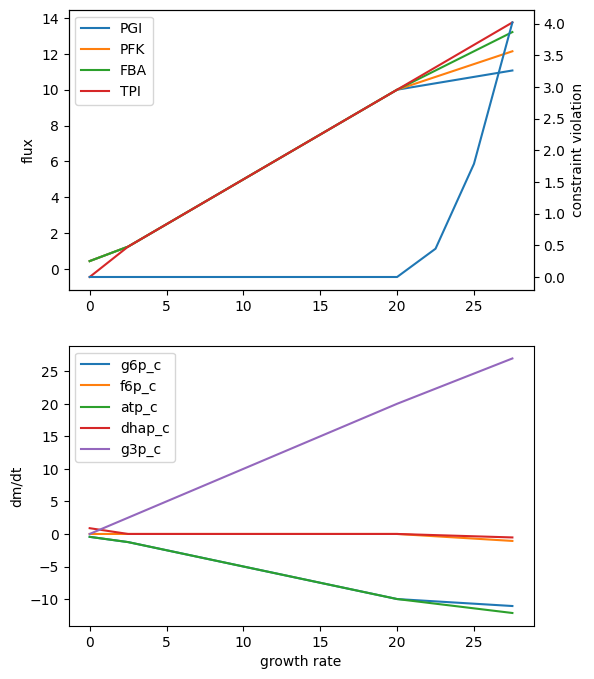

In [26]:
bfba = fba_gd.FbaGd(
    baby,
    intermediates = [baby.reactants[i] for i in b_objectives.objectives["steady-state"].indices],
    objectives={name: objective for name, objective in b_objectives.objectives.items() if name in ["bounds", "growth"]},
    w_fitness=1e4,
)
results = []
for growth_rate in np.arange(0, 30, 2.5):
    result = {"growth_rate": growth_rate}

    bfba.update_params({"growth": growth_rate})
    bsoln = bfba.solve(gtol=1e-12)
    for r, flux in baby.reactions.unpack(bsoln.velocities).items():
        result[r.id] = flux
    for m, d in baby.reactants.unpack(bsoln.dmdt).items():
        result[m.id] = d
    for name, resid in b_objectives.residuals(bsoln.velocities, bsoln.dmdt, {"growth": growth_rate}).items():
        result[name] = np.sum(np.square(resid))
    results.append(result)
results_df = pd.DataFrame(results).set_index("growth_rate")

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].set_ylabel("flux")
for rxn_id in ["PGI", "PFK", "FBA", "TPI"]:
    ax[0].plot(results_df.index, results_df[rxn_id], label=rxn_id)
ax[0].legend()

rax = ax[0].twinx()
rax.set_ylabel("constraint violation")
rax.plot(results_df.index, results_df[b_objectives.objectives.keys()].sum(axis=1))

ax[1].set_ylabel("dm/dt")
for met_id in ["g6p_c", "f6p_c", "atp_c", "dhap_c", "g3p_c"]:
    ax[1].plot(results_df.index, results_df[met_id], label=met_id)
ax[1].set_xlabel("growth rate")
ax[1].legend()
plt.show()

### Try it with LinearConstraint
- Pretty far afield of FbaGd code, and not so different from constructing an LP problem. But try it anyway

In [27]:
col_bounds = [(0, np.inf)]   # growth rate
for rxn in baby.reactions:
    if rxn.reversible:
        col_bounds.append((-np.inf, np.inf))
    else:
        col_bounds.append((0, np.inf))
col_bounds = np.array(col_bounds).T
bbounds = scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1])

# rows = []
# row_bounds = []
# for i in b_objectives.objectives["steady-state"].indices:
#     rows.append(i)
#     row_bounds.append((0, 0))
# for i, (lb, ub) in zip(b_objectives.objectives["bounds"].indices, b_objectives.objectives["bounds"].bounds.T):
#     rows.append(i)
#     row_bounds.append((lb, ub))

# biomass_frac = np.zeros((baby.shape[0], 1))
# for i, frac in zip(b_objectives.objectives["growth"].indices, b_objectives.objectives["growth"].fractions):
#     biomass_frac[i, 0] = -frac
#     rows.append(i)
#     row_bounds.append((0, 0))

biomass_frac = -baby.reactants.pack({baby.reactants[7]: 1.})
aug_matrix = np.hstack([biomass_frac, baby.s_matrix])
constraints = [
    scipy.optimize.LinearConstraint(aug_matrix[b_objectives.objectives["steady-state"].indices], lb=0, ub=0),
    scipy.optimize.LinearConstraint(aug_matrix[b_objectives.objectives["growth"].indices], lb=0, ub=0),
    scipy.optimize.LinearConstraint(
        aug_matrix[b_objectives.objectives["bounds"].indices], 
        lb=b_objectives.objectives["bounds"].bounds[0],
        ub=b_objectives.objectives["bounds"].bounds[1]),
]
# row_bounds = np.array(row_bounds).T
# lconstr = scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [28]:
%%time
hessp = np.zeros_like(bx0)
soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=jax.jit(bfun),
    jac=jax.jit(jax.jacfwd(bfun)),
    hessp=lambda x, v: hessp,
    x0=bx0,
    bounds=scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1]),
    constraints=scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1]),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = baby.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(b_residuals(soln.x)))}")
print()
b_objectives.residuals(velocities, dmdt, {"growth": growth_rate})


Growth rate = 19.99993600020489
Loss = 0.0

CPU times: user 84.9 ms, sys: 5.11 ms, total: 90 ms
Wall time: 88.6 ms


{'steady-state': array([0., 0.]),
 'irrev': Array([0.], dtype=float64),
 'bounds': Array([0., 0.], dtype=float64),
 'growth': array([0.])}

In [29]:
col_bounds = [(0, np.inf)]   # growth rate
for rxn in network.reactions:
    if rxn in flux_targets:
        col_bounds.append(flux_targets[rxn])
    elif rxn.reversible:
        col_bounds.append((-np.inf, np.inf))
    else:
        col_bounds.append((0, np.inf))
col_bounds = np.array(col_bounds).T

rows = []
row_bounds = []
for i in objectives.objectives["steady-state"].indices:
    rows.append(i)
    row_bounds.append((0, 0))
for i, (lb, ub) in zip(objectives.objectives["bounds"].indices, objectives.objectives["bounds"].bounds.T):
    rows.append(i)
    row_bounds.append((lb, ub))

biomass_frac = np.zeros((network.shape[0], 1))
for i, frac in zip(objectives.objectives["growth"].indices, objectives.objectives["growth"].fractions):
    biomass_frac[i, 0] = -frac
    rows.append(i)
    row_bounds.append((0, 0))

aug_matrix = np.hstack([biomass_frac, network.s_matrix])
row_bounds = np.array(row_bounds).T


In [30]:
%%time
xlen = 1 + network.shape[1]
x0=jax.random.uniform(prng, shape=(xlen,))
jac = -jnp.eye(xlen)[0]
hessp = np.zeros(xlen)

soln = scipy.optimize.minimize(
    method="trust-constr",
    fun=lambda x: -x[0].astype(float),
    jac=lambda x: jac,
    hessp=lambda x, v: hessp,
    x0=x0,
    bounds=scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1]),
    constraints=scipy.optimize.LinearConstraint(aug_matrix[rows], lb=row_bounds[0], ub=row_bounds[1]),
    options={"xtol": 1e-12, "gtol": 1e-12},
)

growth_rate = soln.x[0].astype(float)
velocities = soln.x[1:]
dmdt = network.s_matrix @ velocities
print(f"Growth rate = {growth_rate}")
print(f"Loss = {jnp.sum(jnp.square(residuals(soln.x)))}")
print()
objectives.residuals(velocities, dmdt, {"growth": growth_rate})


/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Growth rate = -0.14323160113842123
Loss = 41.90568332670435

CPU times: user 20.2 s, sys: 51.2 s, total: 1min 11s
Wall time: 9.39 s


{'steady-state': array([-0.00177084,  0.34447563, -0.55909635, -0.40177271, -0.21222029,
         0.42998095,  0.24888549,  0.77122194,  0.17101594, -0.01575714,
        -0.0965977 ,  0.25373652, -0.36953541,  0.0071276 ,  0.25356243,
         0.23389329, -0.031019  ,  0.19253258, -0.14207171,  0.29575919,
         0.55878078,  1.63345457,  0.08320438,  0.27114762, -0.23389329,
        -0.35518241,  0.24139225, -0.23382163,  0.34325755]),
 'irrev': Array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.08411689,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],      dtype=float64),
 'bounds': Arra

In [188]:
scipy.optimize.Bounds(lb=col_bounds[0], ub=col_bounds[1])

Bounds(array([0.  , -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0.  , -inf, -inf,
       8.39, -inf, -inf, 0.  , 0.  , -inf, -inf, -inf, -inf, 0.  , 0.  ,
       0.  , 0.  , 0.  , -inf, 0.  , -inf, -inf, 0.  , 0.  , 0.  , -inf,
       0.  , 0.  , -inf, 0.  , -inf, -inf, 0.  , -inf, 0.  , 0.  , -inf,
       0.  , 0.  , 0.  , 0.  , -inf, -inf, 0.  , 0.  , 0.  , -inf, -inf,
       0.  , -inf, -inf, 0.  , 0.  , 0.  , -inf, 0.  , -inf, -inf, -inf,
       0.  , 0.  , 0.  , -inf, -inf, 0.  , -inf, -inf, -inf]), array([  inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf, 1000.,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
         inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,   inf,
  

In [184]:
hessp.shape

(75,)

So the _concept_ of constrained minimization works just fine. But something is not as desired with NonLinearConstraint. Maybe that's just fine: most of the constraints on v or dmdt can be expressed that way. It is less flexible API-wise though. Or at least it will take some serious rethinking.